In [ ]:
import sionna as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import Model
from tensorflow.keras.layers  import Dense
import numpy as np
import pickle
from scipy.special import erfc
from sionna.utils import sim_ber
import utils
from utils.my_utils import ebno_db_setup, load_weights, save_weights, Q_func

In [4]:
BATCH_SIZE = 128 
NUM_BITS_PER_SYMBOL = 4 
weights_path = '/weights'

In [6]:
No = -114       # dBm/Hz
B = 10**6       # 1 MHz
R = 1           # Code rate

EBN0_DB_MIN = ebno_db_setup(-54, No, B, R)
EBN0_DB_MAX = ebno_db_setup(-34, No, B, R)
EBN0_DB_TRAIN = ebno_db_setup(-42, No, B, R)
print(f"EBN0_MIN: {EBN0_DB_MIN:.2f}")
print(f"EBN0_MAX: {EBN0_DB_MAX:.2f}")
print(f"EBN0_TRAIN: {EBN0_DB_TRAIN:.2f}")

EBN0_MIN: 0.00
EBN0_MAX: 20.00
EBN0_TRAIN: 12.00


### APP-based

In [4]:
class Baseline(Model):
  def __init__(self,hard_out,k):
    super().__init__()
    self.binary_source = sn.utils.BinarySource()
    self.constellation = sn.mapping.Constellation("qam", k)
    self.mapper = sn.mapping.Mapper(constellation=self.constellation)
    self.demapper_Baseline = sn.mapping.Demapper("app", constellation=self.constellation, hard_out= hard_out)

    self.awgn_channel = sn.channel.AWGN()
    self.k = k

  def __call__(self, batch_size, ebno_db):
    N0 = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol= self.k, coderate=1.0)
    tx_bits_Baseline = self.binary_source([batch_size, 1200])
    x = self.mapper(tx_bits_Baseline)
    y = self.awgn_channel([x, N0])
    llr_Baseline = self.demapper_Baseline([y, N0])
    return tx_bits_Baseline, llr_Baseline

### DNN Demapper

In [ ]:
# Define the NeuralDemapper model
class NeuralDemapper(Model):
    def __init__(self,NUM_BITS_PER_SYMBOL):
        super(NeuralDemapper, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.dense_3 = Dense(NUM_BITS_PER_SYMBOL, activation=None)

    def call(self, y):
        # Separate real and imaginary parts and stack them
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        # Pass through Dense layers
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z)
        # Reshape the output
        llr_DNN = tf.reshape(z, [tf.shape(y)[0], -1])  
        return llr_DNN

### E2E system using DNN-Demapper

In [6]:
class End2EndSystem_DNN(Model):
  def __init__(self,training_status,k):
    super().__init__()

    self.binary_source = sn.utils.BinarySource()
    self.constellation = sn.mapping.Constellation("qam", k, trainable = True)
    self.mapper = sn.mapping.Mapper(constellation=self.constellation)
    self.demapper_DNN = NeuralDemapper(NUM_BITS_PER_SYMBOL=k)
    
    self.awgn_channel = sn.channel.AWGN()
    self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    self.k = k

    self.training_status = training_status
    
  def  __call__(self, batch_size, ebno_db):
    no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.k, coderate=1.0)

    tx_bits_DNN = self.binary_source([batch_size, 1200])
    x = self.mapper(tx_bits_DNN)
    y = self.awgn_channel([x, no])
    llr_DNN = self.demapper_DNN(y)
    if self.training_status:
      loss = self.bce(tx_bits_DNN, llr_DNN)
      return loss
    else:
      return tx_bits_DNN, llr_DNN

### Training

In [7]:
def training_E2E_model(model,batch_size, ebno_db_train, iterations):

    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            loss = model(batch_size,ebno_db_train)

        grads = tape.gradient(loss, model.trainable_weights)

        # Update model weights
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Print loss every 100 iterations
        if iteration % 100 == 0:
            print(f"Iteration: {iteration}, Loss: {loss.numpy()}")

In [8]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [9]:
def load_weights(model, model_weights_path):
    model(tf.constant(1, tf.int32), tf.constant(1.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

In [ ]:
E2E_DNN_training = End2EndSystem_DNN(True)
training_E2E_model(E2E_DNN_training,batch_size=BATCH_SIZE,ebno_db_train = EBN0_DB_TRAIN, iterations = 10000)
model_weights_DNN = weights_path + f'/weights of NeuralDemapperDNN_16QAM_final'  #change the saved path here
save_weights(E2E_DNN_training,model_weights_DNN)

### Evaluation

In [10]:
ebno_dbs_eval = np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20)

In [11]:
model_baseline_16 = Baseline(False,k=4)
ber_baseline_16,_ = sim_ber(model_baseline_16, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4119e-01 | 1.0000e+00 |       21687 |      153600 |          128 |         128 |         0.3 |reached target block errors
    1.053 | 1.1714e-01 | 1.0000e+00 |       17992 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 9.6309e-02 | 1.0000e+00 |       14793 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 7.4492e-02 | 1.0000e+00 |       11442 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 5.4408e-02 | 1.0000e+00 |        8357 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 3.7806e-02 | 1.0000e+00 |        5807 |      153600 

In [12]:
model_baseline_64 = Baseline(False,k=6)
ber_baseline_64,_ = sim_ber(model_baseline_64, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.0031e-01 | 1.0000e+00 |       30768 |      153600 |          128 |         128 |         0.2 |reached target block errors
    1.053 | 1.7513e-01 | 1.0000e+00 |       26900 |      153600 |          128 |         128 |         0.2 |reached target block errors
    2.105 | 1.5499e-01 | 1.0000e+00 |       23807 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.3269e-01 | 1.0000e+00 |       20381 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.1415e-01 | 1.0000e+00 |       17534 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 9.6237e-02 | 1.0000e+00 |       14782 |      153600 |

In [13]:
model_baseline_256 = Baseline(False,k=8)
ber_baseline_256,_ = sim_ber(model_baseline_256, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.5613e-01 | 1.0000e+00 |       39341 |      153600 |          128 |         128 |         0.3 |reached target block errors
    1.053 | 2.3314e-01 | 1.0000e+00 |       35810 |      153600 |          128 |         128 |         0.3 |reached target block errors
    2.105 | 2.1364e-01 | 1.0000e+00 |       32815 |      153600 |          128 |         128 |         0.3 |reached target block errors
    3.158 | 1.9437e-01 | 1.0000e+00 |       29856 |      153600 |          128 |         128 |         0.3 |reached target block errors
    4.211 | 1.7538e-01 | 1.0000e+00 |       26939 |      153600 |          128 |         128 |         0.2 |reached target block errors
    5.263 | 1.5486e-01 | 1.0000e+00 |       23787 |      153600 |

In [16]:
model_weights_DNN_16 = weights_path + f'/weights of NeuralDemapperDNN_16QAM_12dB'
model_DNN_16 = End2EndSystem_DNN(False,k= 4)
load_weights(model_DNN_16, model_weights_DNN_16)
ber_DNN_16,_ = sim_ber(model_DNN_16, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4143e-01 | 1.0000e+00 |       21723 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.1756e-01 | 1.0000e+00 |       18057 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 9.6029e-02 | 1.0000e+00 |       14750 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 7.3913e-02 | 1.0000e+00 |       11353 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 5.4447e-02 | 1.0000e+00 |        8363 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 3.8027e-02 | 1.0000e+00 |        5841 |      153600 |

In [17]:
model_weights_DNN_64 = weights_path + f'/weights of NeuralDemapperDNN_64QAM_12dB'
model_DNN_64 = End2EndSystem_DNN(False,k= 6)
load_weights(model_DNN_64, model_weights_DNN_64)
ber_DNN_64,_ = sim_ber(model_DNN_64, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9947e-01 | 1.0000e+00 |       30639 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.7485e-01 | 1.0000e+00 |       26857 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 1.5163e-01 | 1.0000e+00 |       23291 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.3152e-01 | 1.0000e+00 |       20201 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.1116e-01 | 1.0000e+00 |       17074 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 9.3320e-02 | 1.0000e+00 |       14334 |      153600 |

In [18]:
model_weights_DNN_256 = weights_path + f'/weights of NeuralDemapperDNN_256QAM_12dB'
model_DNN_256 = End2EndSystem_DNN(False,k= 8)
load_weights(model_DNN_256, model_weights_DNN_256)
ber_DNN_256,_ = sim_ber(model_DNN_256, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4798e-01 | 1.0000e+00 |       38090 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 2.2811e-01 | 1.0000e+00 |       35037 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 2.0716e-01 | 1.0000e+00 |       31820 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.8680e-01 | 1.0000e+00 |       28693 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.6548e-01 | 1.0000e+00 |       25418 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 1.4766e-01 | 1.0000e+00 |       22680 |      153600 |

### Plot out

In [ ]:
new_blue = '#36A2EB'     # Vibrant medium blue
new_teal = '#4BC0C0'     # Cyan-green teal
new_orange = '#E67E22'   # Warm orange

In [ ]:
#Theoretical Line
def theo_ber_M_qam(eb_no_db, M):
  assert isinstance(M, int)
  assert M > 0
  eb_no = 10**(eb_no_db / 10)
  
  if M %4==0:
    d_min = 6*np.log2(M)/ (M-1)
    BER = 1/np.log2(M) *4*(1- 1/np.sqrt(M)) * Q_func(np.sqrt( (d_min/2) *eb_no))
  return BER

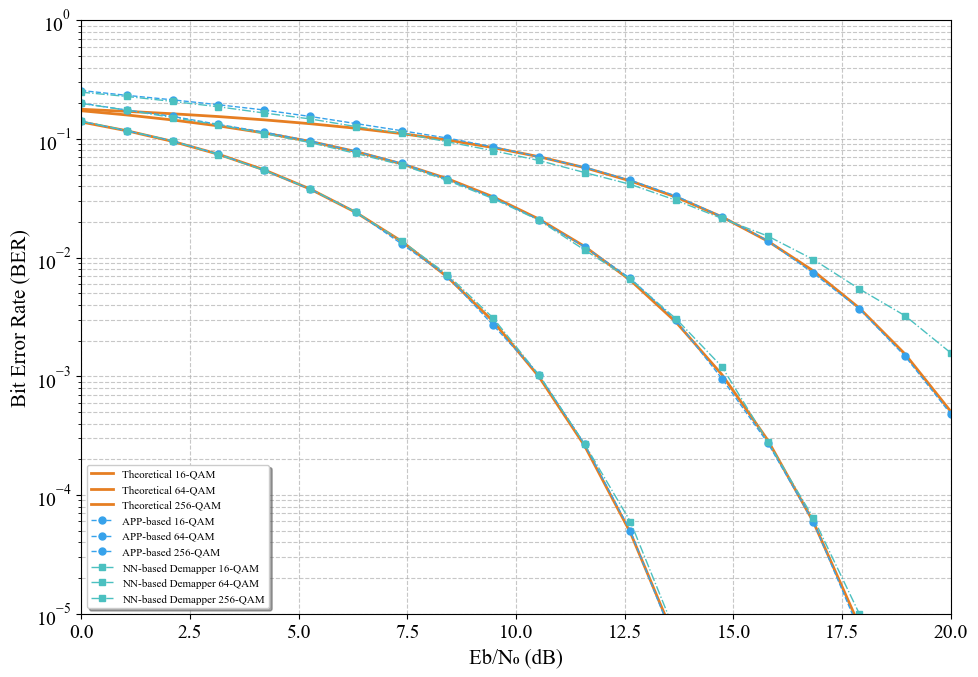

In [ ]:
# Font settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 14

# Sample Eb/N0 range and theoretical BERs
eb_no_db_range = np.linspace(0, 20, 20)

ber_16_theo = theo_ber_M_qam(eb_no_db_range, 16)
ber_64_theo = theo_ber_M_qam(eb_no_db_range, 64)
ber_256_theo = theo_ber_M_qam(eb_no_db_range, 256)

# # Create figure
plt.figure(figsize=(10, 7))

# Theoretical curves
plt.semilogy(eb_no_db_range, ber_16_theo, '-',color = new_orange, linewidth=2, label='Theoretical 16-QAM')
plt.semilogy(eb_no_db_range, ber_64_theo, '-',color = new_orange, linewidth=2, label='Theoretical 64-QAM')
plt.semilogy(eb_no_db_range, ber_256_theo, '-',color = new_orange, linewidth=2, label='Theoretical 256-QAM')

# Baseline LLR-based results
plt.semilogy(eb_no_db_range, ber_baseline_16, 'o--',color = new_blue, markersize=5, linewidth=1, label='APP-based 16-QAM ')
plt.semilogy(eb_no_db_range, ber_baseline_64, 'o--',color = new_blue, markersize=5, linewidth=1, label='APP-based 64-QAM ')
plt.semilogy(eb_no_db_range, ber_baseline_256, 'o--',color = new_blue, markersize=5, linewidth=1, label='APP-based 256-QAM ')

# DNN-based results
plt.semilogy(eb_no_db_range, ber_DNN_16, 's-.',color = new_teal, markersize=5, linewidth=1, label='NN-based Demapper 16-QAM')
plt.semilogy(eb_no_db_range, ber_DNN_64, 's-.',color = new_teal, markersize=5, linewidth=1, label='NN-based Demapper 64-QAM')
plt.semilogy(eb_no_db_range, ber_DNN_256, 's-.',color = new_teal, markersize=5, linewidth=1, label='NN-based Demapper 256-QAM')

# Labels, grid, and title
plt.xlabel('Eb/N₀ (dB)', fontsize=15)
plt.ylabel('Bit Error Rate (BER)', fontsize=15)

# Grid and axis formatting
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)
plt.ylim(1e-5, 1)
plt.xlim(0, 20)

# Legend styling
plt.legend(loc='lower left', fontsize=8, frameon=True, shadow=True, fancybox=True)

# Ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()